In [2]:
library(tidyverse)
library(repr)
library(readxl)
options(repr.matrix.max.rows = 6)
library(rvest)
library(rsample)
library(RCurl)
library(tidymodels)
library(ggplot2)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘rvest’ was built under R version 4.0.2”
Loading required package: xml2


Attaching package: ‘rvest’


The following object is masked from ‘package:purrr’:

    pluck


The following object is masked from ‘package:readr’:

    guess_encoding



Attaching package: ‘RCurl’


The following object is masked from ‘packag

In [3]:
rice <- read_csv("https://raw.githubusercontent.com/alice-shin/DSCI100Project/main/Rice_Osmancik_Cammeo_Dataset.csv")
glimpse(rice)

Parsed with column specification:
cols(
  AREA = col_double(),
  PERIMETER = col_double(),
  MAJORAXIS = col_double(),
  MINORAXIS = col_double(),
  ECCENTRICITY = col_double(),
  CONVEX_AREA = col_double(),
  EXTENT = col_double(),
  CLASS = col_character()
)



Rows: 3,810
Columns: 8
$ AREA         <dbl> 15231, 14656, 14634, 13176, 14688, 13479, 15757, 16405, …
$ PERIMETER    <dbl> 525.579, 494.311, 501.122, 458.343, 507.167, 477.016, 50…
$ MAJORAXIS    <dbl> 229.7499, 206.0201, 214.1068, 193.3374, 211.7434, 200.05…
$ MINORAXIS    <dbl> 85.09379, 91.73097, 87.76829, 87.44839, 89.31245, 86.650…
$ ECCENTRICITY <dbl> 0.9288820, 0.8954050, 0.9121181, 0.8918609, 0.9066909, 0…
$ CONVEX_AREA  <dbl> 15617, 15072, 14954, 13368, 15262, 13786, 16150, 16837, …
$ EXTENT       <dbl> 0.5728955, 0.6154363, 0.6932588, 0.6406690, 0.6460239, 0…
$ CLASS        <chr> "Cammeo", "Cammeo", "Cammeo", "Cammeo", "Cammeo", "Camme…


In [4]:
#Clean, Wrangling, and Exploring the Data

rice <- rice %>%
    mutate(CLASS = as_factor(CLASS))

#Creating train / test split

set.seed(1)
rice_split <- initial_split(rice, prop = 0.75, strata = CLASS)
rice_train <- training(rice_split)
rice_test <- testing(rice_split)

rice_summary_by_class <- group_by(rice_train, CLASS)%>%
    summarize(
        area = mean(AREA),
        perimeter = mean(PERIMETER),
        majoraxis = mean(MAJORAXIS),
        minoraxis = mean(MINORAXIS),
        eccentricity = mean(ECCENTRICITY),
        convex_area = mean(CONVEX_AREA),
        extent = mean(EXTENT))
rice_summary_by_class

`summarise()` ungrouping output (override with `.groups` argument)



CLASS,area,perimeter,majoraxis,minoraxis,eccentricity,convex_area,extent
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cammeo,14154.65,487.2135,205.3067,88.78896,0.900838,14487.39,0.6511316
Osmancik,11535.21,429.1657,176.2292,84.39818,0.876432,11784.54,0.6702400


Table 1: Mean values for each explanatory variable grouped by CLASS

In [5]:
num_obs <- nrow(rice_train)
rice_train %>%
    group_by(CLASS)%>%
    summarize(
        n = n(),
        percentage = n() / num_obs*100)

`summarise()` ungrouping output (override with `.groups` argument)



CLASS,n,percentage
<fct>,<int>,<dbl>
Cammeo,1223,42.79216
Osmancik,1635,57.20784


Table 2: Number and percentage of observations by CLASS

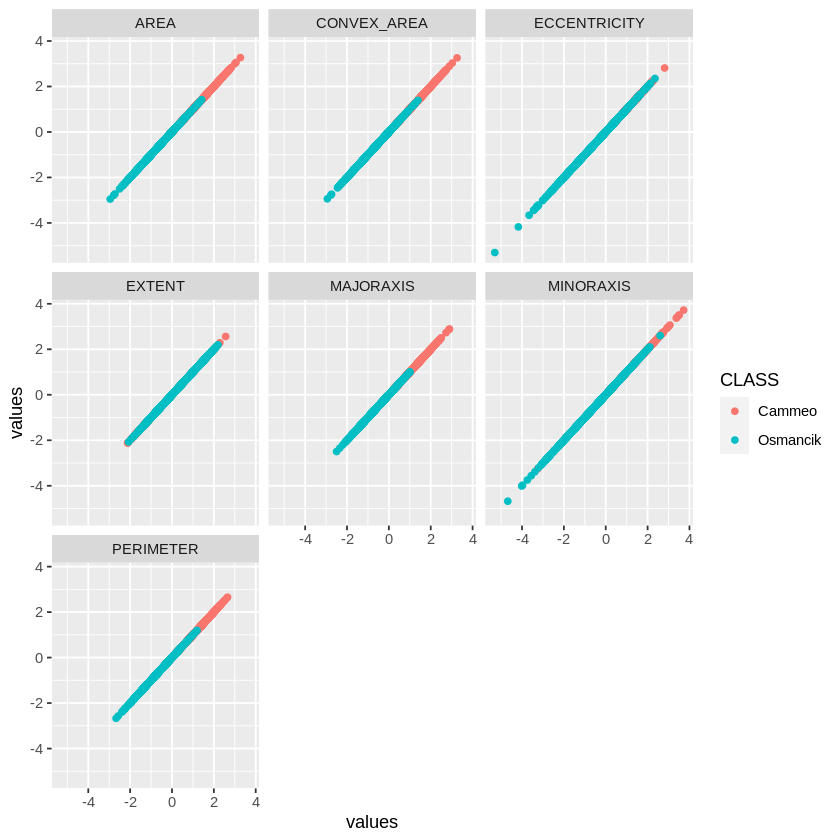

In [7]:

rice_scaled <-rice_train %>%
    select(-CLASS)%>%
    map(scale)%>%
    bind_cols()%>%
    mutate(CLASS = rice_train$CLASS)

rice_vis <- pivot_longer(rice_scaled, 
                        cols = AREA:EXTENT,
                        names_to = "variables",
                        values_to = "values")

ggplot(rice_vis, aes(x=values, y=values, color=CLASS))+
    geom_point()+
    facet_wrap(~variables)


Figure 1: Graph of standardized values plotted by explanatory variables and coloured by CLASS

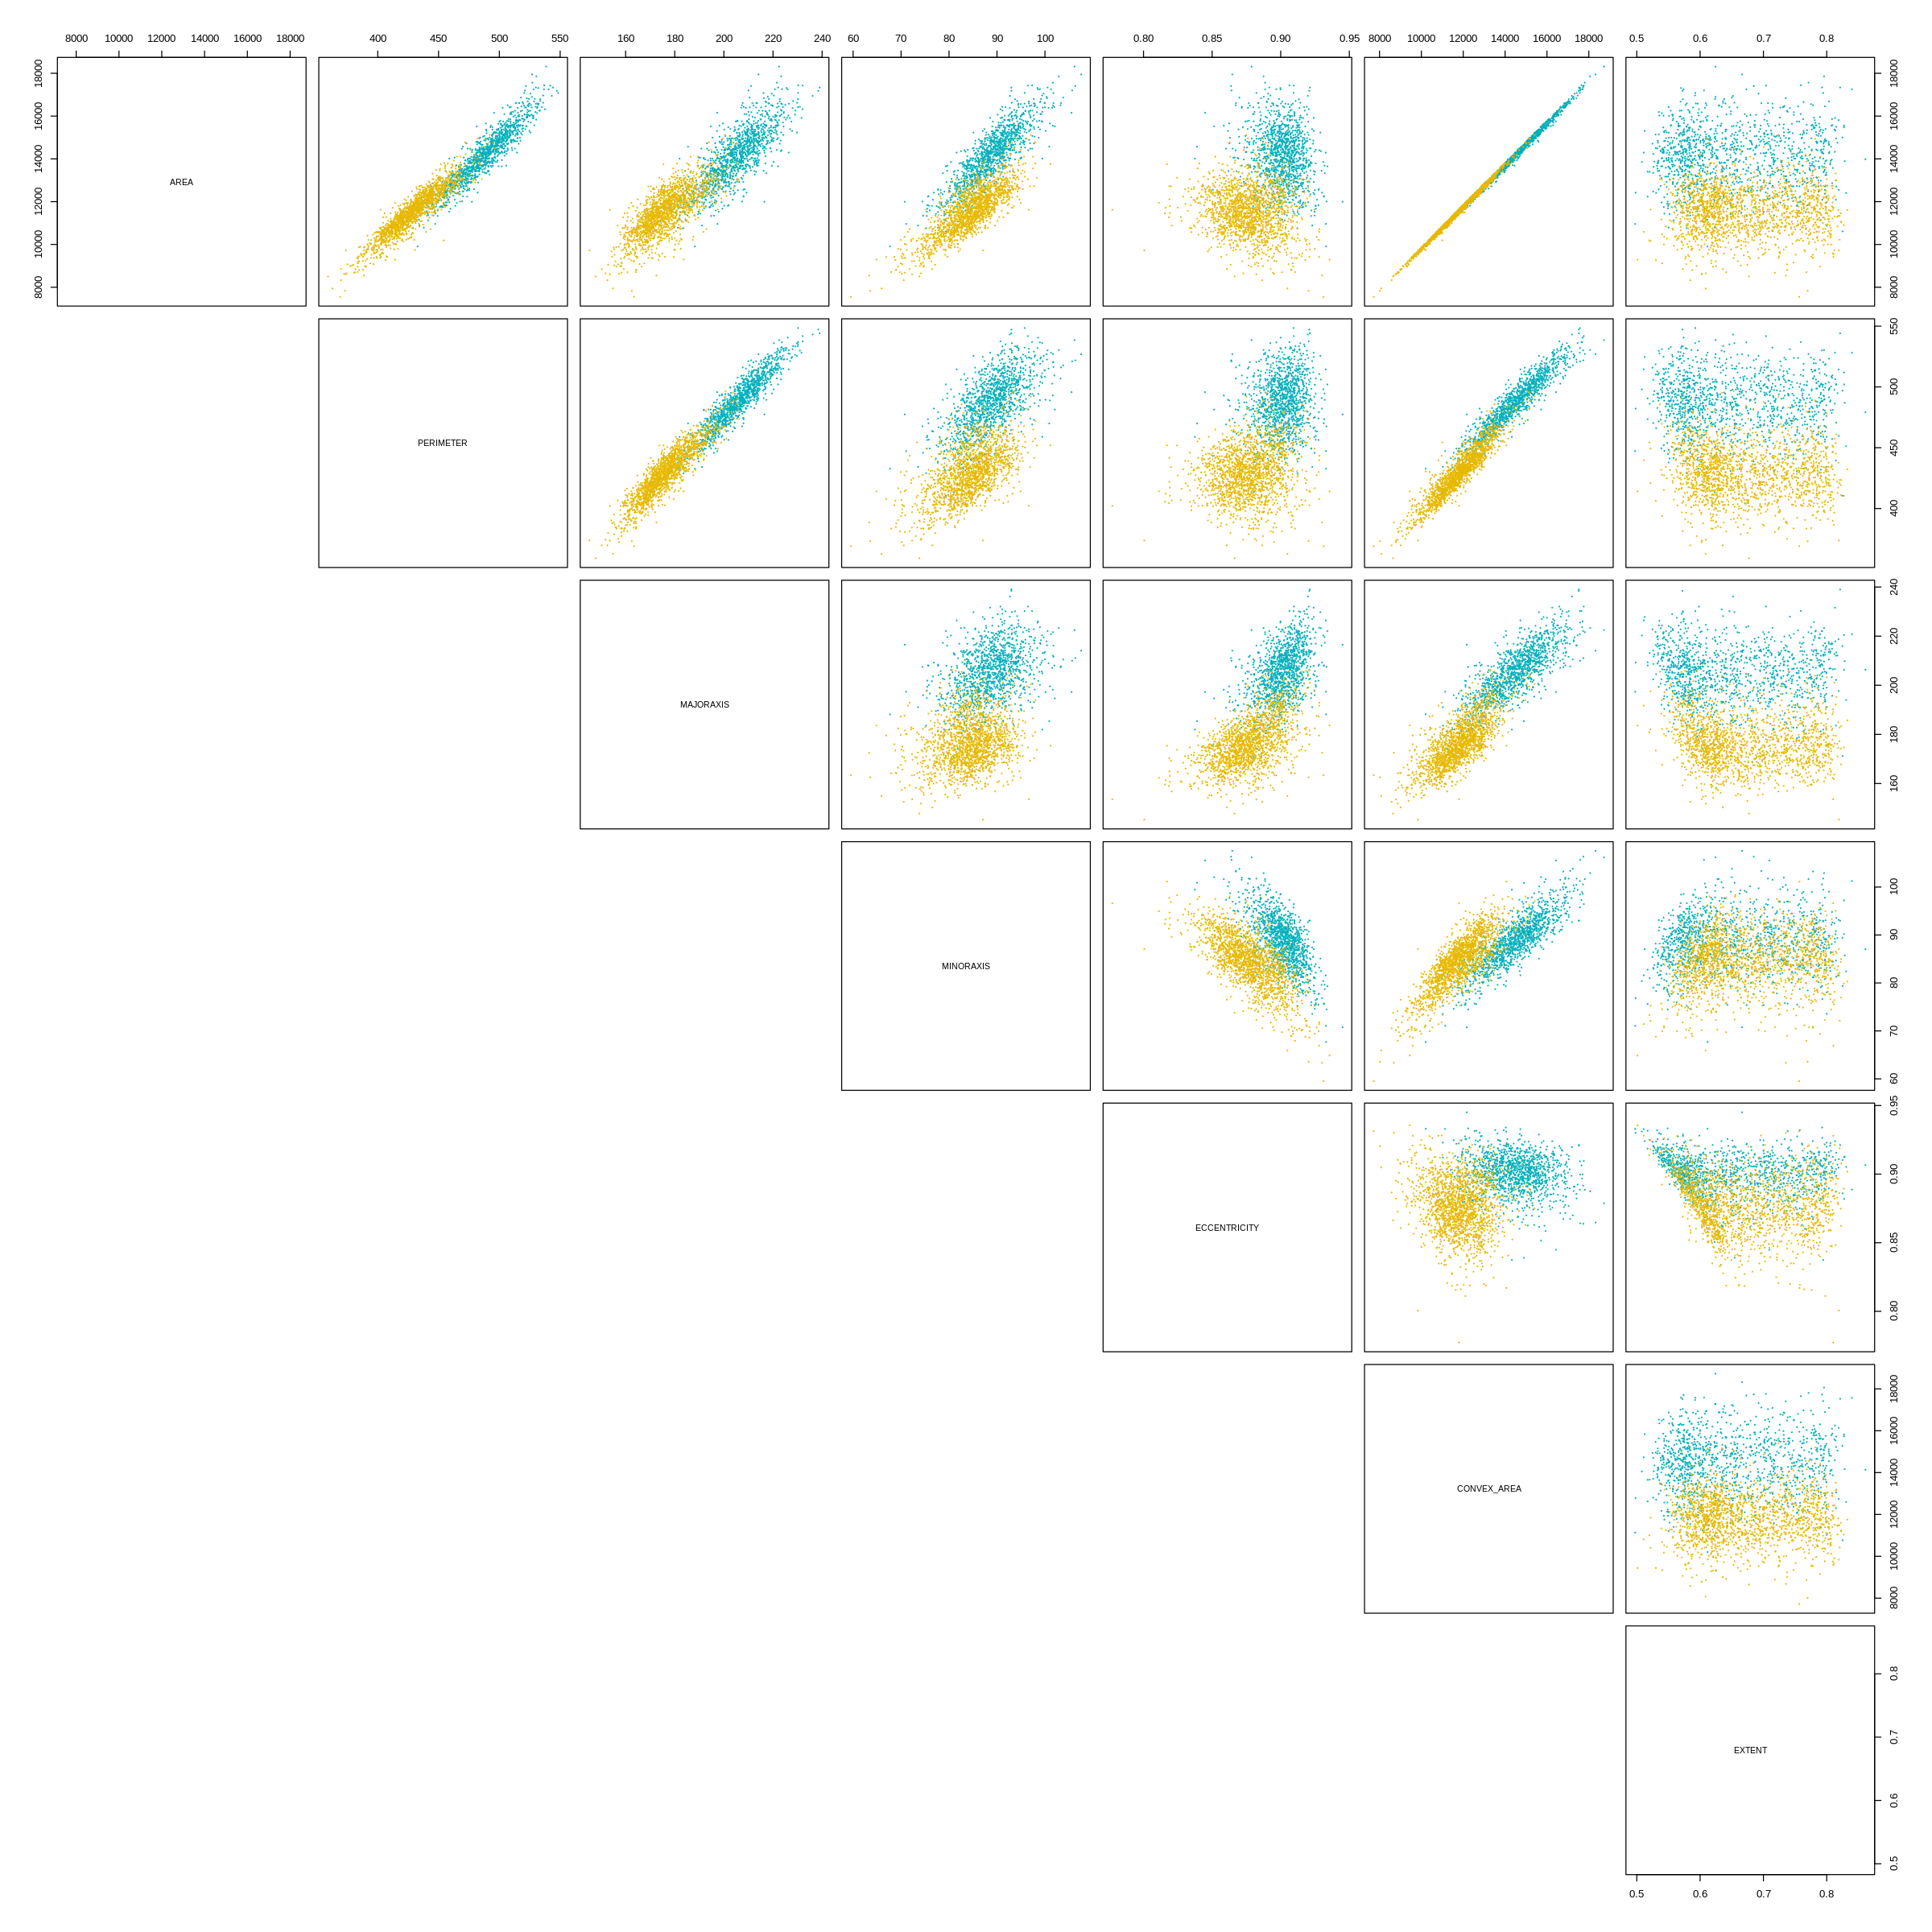

In [302]:
exp_vars <- rice_train %>%
    select(-CLASS)
my_cols <- c("#00AFBB", "#E7B800")
pairs(exp_vars, col = my_cols[rice_train$CLASS], lower.panel = NULL, cex=0.1)

Figure 2: Scatter plot matrix of explanatory variables coloured by CLASS

In [8]:
#Data pre-processing

rice_recipe <- recipe(CLASS ~., data = rice_train)%>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

#Training the classifier

set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow()%>%
    add_recipe(rice_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = rice_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.08257523
Best kernel: rectangular
Best k: 5

In [9]:
#Tune Using cross-validation
set.seed(2)


accuracies <- c()
for (i in 1:5) {
    set.seed(i)

    rice_split <- initial_split(rice_train, prop = 0.75, strata = CLASS)
    rice_subtrain <- training(rice_split)
    rice_validation <- testing(rice_split)
    
    rice_recipe <- recipe(CLASS ~., data = rice_subtrain)%>%
        step_scale(all_predictors())%>%
        step_center(all_predictors())
    
    knn_fit <- workflow()%>%
        add_recipe(rice_recipe)%>%
        add_model(knn_spec)%>%
        fit(data = rice_subtrain)
    
    validation_predicted <- predict(knn_fit, rice_validation)%>%
        bind_cols(rice_validation)
    
    acc <- validation_predicted %>%
        metrics(truth = CLASS, estimate = .pred_class)%>%
        filter(.metric =="accuracy")%>%
        select(.estimate)%>%
        pull()
    
    accuracies <- append(accuracies, acc)
}

accuracies


[1] 0.9074334 0.9186536 0.9200561 0.9200561 0.9172511

In [10]:
rice_vfold <- vfold_cv(rice_train, v=5, strata=CLASS)

In [11]:
set.seed(1)

rice_recipe <- recipe(CLASS ~ ., data = rice_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit <- workflow() %>%
  add_recipe(rice_recipe) %>%
  add_model(knn_spec) %>%
  fit_resamples(resamples = rice_vfold)


In [12]:
knn_fit %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,binary,0.9170729,5,0.004421614
roc_auc,binary,0.9565266,5,0.002474375


Table 3: Metrics of the classifer's validation accuracy across folds

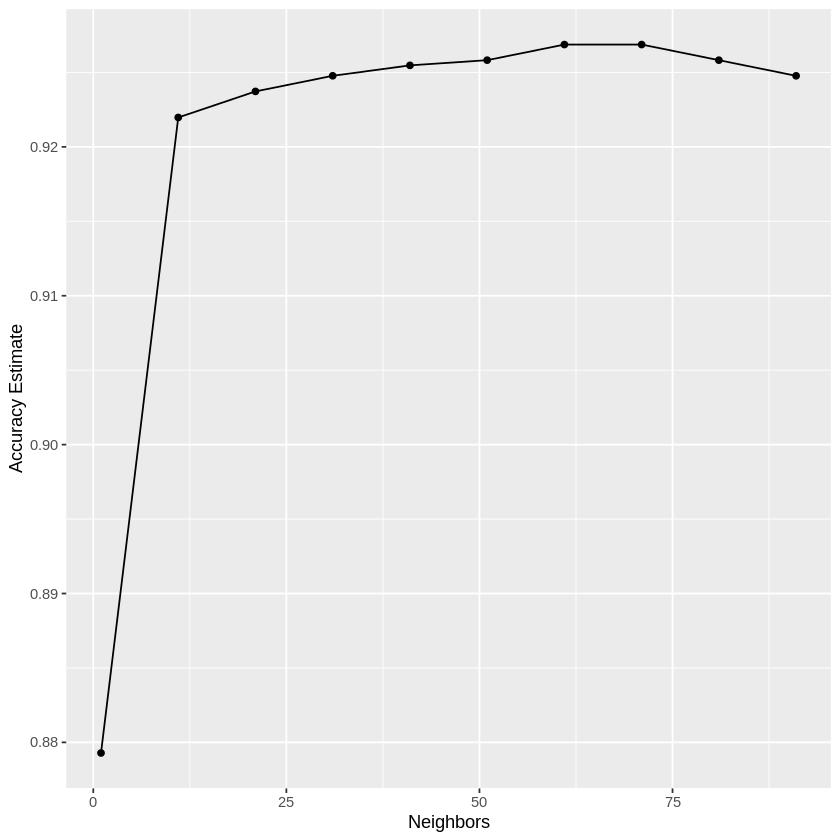

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

set.seed(1)
k_lots <- tibble(neighbors = seq(from = 1, to = 100, by = 10))
knn_results <- workflow() %>%
  add_recipe(rice_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = rice_vfold, grid = k_lots) %>%
  collect_metrics()

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_vs_k

Figure 3: Plot of accuracies vs. K

In [14]:
#Choose K = 62
#Training the classifier

set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 62) %>%
    set_engine("kknn") %>%
    set_mode("classification")

knn_fit <- workflow()%>%
    add_recipe(rice_recipe)%>%
    add_model(knn_spec)%>%
    fit(data = rice_train)

knn_fit

#Predicting the test set

rice_test_predictions <- predict(knn_fit, rice_test)%>%
    bind_cols(rice_test)
rice_test_predictions




══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~62, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.07417775
Best kernel: rectangular
Best k: 62

.pred_class,AREA,PERIMETER,MAJORAXIS,MINORAXIS,ECCENTRICITY,CONVEX_AREA,EXTENT,CLASS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cammeo,14688,507.167,211.7434,89.31245,0.9066909,15262,0.6460239,Cammeo
Cammeo,13500,476.915,202.5467,85.40547,0.9067549,13800,0.7177033,Cammeo
Cammeo,13509,480.466,207.1372,83.94016,0.9142106,13732,0.5956349,Cammeo
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Osmancik,9405,389.775,162.3682,74.43763,0.8887205,9594,0.6076366,Osmancik
Osmancik,11441,415.858,170.4868,85.75659,0.8642805,11628,0.6810119,Osmancik
Osmancik,11434,404.710,161.0793,90.86819,0.8256922,11591,0.8029494,Osmancik


Table 4:Predictions of the test set

In [15]:
#Computing accuracy

rice_test_predictions %>%
    metrics(truth = CLASS, estimate = .pred_class)
rice_test_predictions %>%
    conf_mat(truth = CLASS, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9285714
kap,binary,0.8539858


          Truth
Prediction Cammeo Osmancik
  Cammeo      372       33
  Osmancik     35      512

Table 5: Metrics of the model
Table 6: Confusion matrix of the model